In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Start date
start = '2009-06-10'
## CoinMetrics data
data = pd.read_csv('https://community-api.coinmetrics.io/v2/assets/btc/metricdata.csv?metrics=PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,FeeTotUSD,FeeTotNtv,IssContNtv,BlkCnt,DiffMean,SplyCur,AdrActCnt&start='+start, index_col = 0, parse_dates=True)
# Remove time-zone stamp from index
data.index = data.index.tz_convert(None)

## Blockchain.com wallets data
timespan = 'all'
w_data = pd.read_csv('https://api.blockchain.info/charts/my-wallet-n-users?timespan='+timespan+'&format=csv', header=None, infer_datetime_format =True)
w_data.columns = ['Date', 'nWallets']
## Parsing date
w_data['Date'] = w_data['Date'].apply(lambda x: datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
## Eliminate 'intra day' data
w_data['Date'] = w_data['Date'].drop_duplicates(keep='last')
w_data = w_data[w_data['Date'].notnull()]
## Date to index
w_data.set_index('Date', inplace=True, drop=True)
## Merge dataframes
data = pd.concat([data, w_data], axis=1, sort=True, join='outer')
## Fill empty cells
data['nWallets'] = data['nWallets'].ffill(axis = 0)

In [2]:
## MVRV

## Realized Price
data['Realized Price'] = data['CapRealUSD'] / data['SplyCur']

## MVRV Ratio
data['MVRV'] = data['CapMrktCurUSD'] / data['CapRealUSD']
## MVRV-z
per = 200
data['MVRV-z'] = (data['MVRV'] - data['MVRV'].rolling(per).mean()) / data['MVRV'].rolling(per).std()

## Price to MVRV (PTM)
data['PTM'] = data['PriceUSD'] * data['MVRV'].mean()

<AxesSubplot:>

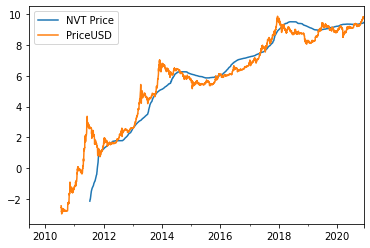

In [3]:
## NVT

## NVT Ratio
data['NVT'] = data['PriceUSD'] / data['TxTfrValAdjUSD']
## NVT Price
per = 360
data['NVT Price'] = (data['NVT'].mean() * data ['TxTfrValAdjUSD']).rolling(per).median()

np.log(data[['NVT Price', 'PriceUSD']]).plot()

In [4]:
## Avoided Costs

## Open csv
avdd_cost = pd.read_csv('Data/Avoided Costs.csv')
avdd_cost.columns = ('Date', 'AC Price')
## Fix index
avdd_cost.set_index('Date', inplace=True)
avdd_cost.index = pd.to_datetime(avdd_cost.index)
## Join DataFrame
data = data.join(avdd_cost)

S2F Price = 3.22 * log(S2F) + -1.61
r2 = 0.94


<ipython-input-5-cd9b47271b35>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_data.dropna(thresh = 2, inplace=True)


<AxesSubplot:>

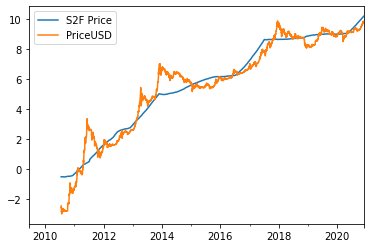

In [5]:
## Stock-to-Flow

## S2F Ratio
data['S2F'] = data['SplyCur'] / data['IssContNtv'].rolling(360).sum()

w_data = data[['S2F', 'PriceUSD']]
w_data.dropna(thresh = 2, inplace=True)

log_s2f = np.log(w_data['S2F']).values.reshape(-1, 1)
log_price = np.log(w_data['PriceUSD']).values.reshape(-1, 1)

reg = LinearRegression().fit(log_s2f, log_price)

a = reg.coef_[0][0]
b = reg.intercept_[0]

data['S2F Price'] = np.exp(np.log(w_data['S2F']) * a + b)

r2 = reg.score(log_s2f, log_price)

print('S2F Price = '+str(a.round(2))+' * log(S2F) + '+str(b.round(2)))
print('r2 = '+str(r2.round(2)))
np.log(data[['S2F Price', 'PriceUSD']]).plot()

In [6]:
## Metcalfe's Law

## Cost of Production

## Open csv
metcalfe = pd.read_csv('Data/Metcalfe.csv')
metcalfe.columns = ('Date', 'DAA Metcalfe Price', 'Metcalfe Price')

## Fix index
metcalfe.set_index('Date', inplace=True)
metcalfe.index = pd.to_datetime(metcalfe.index)

## Join DataFrame
data = data.join(metcalfe)

In [8]:
## Create .csv file

data = data[['PriceUSD', 'Realized Price', 'NVT Price', 'AC Price', 'Metcalfe Price', 'S2F Price']]
## Translate to Portuguese
data.columns = [['Preço', 'Preço Realizado', 'Preço de NVT', 'Custos Evitados', 'Preço de Metcalfe', 'Preço de Estoque-Fluxo']]
## Drop NaN
data.dropna(thresh = 6, inplace = True)
## Save as .csv
data.to_csv('metrics.csv')

<ipython-input-8-797a82a6eec7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(thresh = 6, inplace = True)


In [ ]:
data